In [119]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps
from tqdm import trange 
from src.LMF import LMF, update_code_within_radius
from src.SNMF import SNMF
from sklearn.model_selection import StratifiedKFold

# statistical test
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from scipy import stats
from scipy.stats import ranksums

In [24]:
os.chdir('../')
os.getcwd()

'/bigdata/statsdept'

In [29]:
clinical_path = "shared/data/LungSegmentation/ClinicalReadings/"
image_path = "shared/data/LungSegmentation/CXR_png/"

In [45]:
clinical_data_txt = os.listdir(clinical_path)
ids = ' '.join(map(str, clinical_data_txt)).replace(".txt", "").split()
clinical_data = []

for idx, one_diagnosis in zip(ids, clinical_data_txt):
    #print(idx, one_diagnosis)
    with open(clinical_path + one_diagnosis) as f:
        info = []
        for line in f:
            line = line.lower().strip()
            
            if "mal" in line and "normal" not in line and len(line) < 20:    
                line = line.replace(",", "")
                line = line.replace(" ", "")
                match = re.match(r"([a-z]+)([0-9]+)", line, re.I)
                
                if match:
                    line = " ".join(match.groups())
                    
                sex, age = zip(line.split())
                info.extend([list(sex), list(age)])
                continue
                
            info.append([line])
            
        info = [i for i in info if i != ['']]
        info.insert(0, [idx])
        info[3:] = [[i[0] for i in info[3:]]]
        info = [i[0] for i in info]

        clinical_data.append(info)

clinical_data = pd.DataFrame(clinical_data, columns=["Id", "Sex", "Age", "Diagnosis"])
clinical_data

,Id,Sex,Age,Diagnosis
0,CHNCXR_0541_1,male,23,ptb in the right upper field
1,MCUCXR_0038_0,patient's sex: f,patient's age: 031y,normal
2,MCUCXR_0069_0,patient's sex: m,patient's age: 050y,normal
3,CHNCXR_0154_0,male,31,normal
4,MCUCXR_0082_0,patient's sex: f,patient's age: 020y,normal
...,...,...,...,...
795,CHNCXR_0090_0,male,39,normal
796,MCUCXR_0331_1,patient's sex: m,patient's age: 047y,inactive appearing rul tb scars
797,CHNCXR_0331_1,female,36,stb
798,CHNCXR_0661_1,male,26,bilateral secondary ptb with right pleural th...


In [46]:
clinical_data["Sex"] = clinical_data["Sex"].replace({"patient's sex: f": "female",
                                                     "patient's sex: m": "male",
                                                     "femal": "female",
                                                     "patient's sex: o": "male"})
clinical_data

,Id,Sex,Age,Diagnosis
0,CHNCXR_0541_1,male,23,ptb in the right upper field
1,MCUCXR_0038_0,female,patient's age: 031y,normal
2,MCUCXR_0069_0,male,patient's age: 050y,normal
3,CHNCXR_0154_0,male,31,normal
4,MCUCXR_0082_0,female,patient's age: 020y,normal
...,...,...,...,...
795,CHNCXR_0090_0,male,39,normal
796,MCUCXR_0331_1,male,patient's age: 047y,inactive appearing rul tb scars
797,CHNCXR_0331_1,female,36,stb
798,CHNCXR_0661_1,male,26,bilateral secondary ptb with right pleural th...


In [47]:
age_list = clinical_data["Age"].apply(lambda line: re.findall(r'([1-9]\d+|[1-9])', line)).values

clinical_data["Age"] = [int(age[0]) for age in age_list]
clinical_data

,Id,Sex,Age,Diagnosis
0,CHNCXR_0541_1,male,23,ptb in the right upper field
1,MCUCXR_0038_0,female,31,normal
2,MCUCXR_0069_0,male,50,normal
3,CHNCXR_0154_0,male,31,normal
4,MCUCXR_0082_0,female,20,normal
...,...,...,...,...
795,CHNCXR_0090_0,male,39,normal
796,MCUCXR_0331_1,male,47,inactive appearing rul tb scars
797,CHNCXR_0331_1,female,36,stb
798,CHNCXR_0661_1,male,26,bilateral secondary ptb with right pleural th...


In [49]:
clinical_data["disease"] = "_"
clinical_data.loc[(clinical_data["Diagnosis"].str.contains("granulomas|granuloma|cavitary") & (clinical_data["disease"] == "_")), ["disease"]] = "granuloma|cavitary"
clinical_data.loc[(clinical_data["Diagnosis"].str.contains("pneumothorax|volume loss") & (clinical_data["disease"] == "_")), ["disease"]] = "pneumothorax"
clinical_data.loc[(clinical_data["Diagnosis"].str.contains("atelectasis") & (clinical_data["disease"] == "_")), ["disease"]] = "atelectasis"
clinical_data.loc[(clinical_data["Diagnosis"].str.contains("pleurisy") & (clinical_data["disease"] == "_")), ["disease"]] = "pleurisy"
clinical_data.loc[(clinical_data["Diagnosis"].str.contains("pneumonia") & (clinical_data["disease"] == "_")), ["disease"]] = "pneumonia"
clinical_data.loc[(clinical_data["Diagnosis"].str.contains("pleural thickening") & (clinical_data["disease"] == "_")), ["disease"]] = "pleural thickening"
clinical_data.loc[(clinical_data["Diagnosis"].str.contains("infiltrate") & (clinical_data["disease"] == "_")), ["disease"]] = "infiltrate"
clinical_data.loc[(clinical_data["Diagnosis"].str.contains("fibrous|fibrosis|scar") & (clinical_data["disease"] == "_")), ["disease"]] = "fibrosis"
clinical_data.loc[(clinical_data["Diagnosis"].str.contains("stb|ptb|tb|tuberculosis") & (clinical_data["disease"] == "_")), ["disease"]] = "tuberculosis"
clinical_data.loc[(clinical_data["Diagnosis"].str.contains("nolrmale") & (clinical_data["disease"] == "_")), ["disease"]] = "no pathology"
clinical_data.loc[(clinical_data["Diagnosis"] == "normal") & (clinical_data["disease"] == "_"), ["disease"]] = "no pathology"
clinical_data.loc[clinical_data["disease"] == "_", ["disease"]] = "unknown"

In [51]:
clinical_data["disease"].value_counts()

no pathology          405
tuberculosis          315
granuloma|cavitary     18
fibrosis               15
infiltrate             14
pleurisy                9
unknown                 7
pleural thickening      5
pneumothorax            5
atelectasis             4
pneumonia               3
Name: disease, dtype: int64

In [52]:
clinical_data["target"] = 0
clinical_data.loc[clinical_data["disease"] == "tuberculosis", ["target"]] = 1
clinical_data

,Id,Sex,Age,Diagnosis,disease,target
0,CHNCXR_0541_1,male,23,ptb in the right upper field,tuberculosis,1
1,MCUCXR_0038_0,female,31,normal,no pathology,0
2,MCUCXR_0069_0,male,50,normal,no pathology,0
3,CHNCXR_0154_0,male,31,normal,no pathology,0
4,MCUCXR_0082_0,female,20,normal,no pathology,0
...,...,...,...,...,...,...
795,CHNCXR_0090_0,male,39,normal,no pathology,0
796,MCUCXR_0331_1,male,47,inactive appearing rul tb scars,fibrosis,0
797,CHNCXR_0331_1,female,36,stb,tuberculosis,1
798,CHNCXR_0661_1,male,26,bilateral secondary ptb with right pleural th...,pleural thickening,0


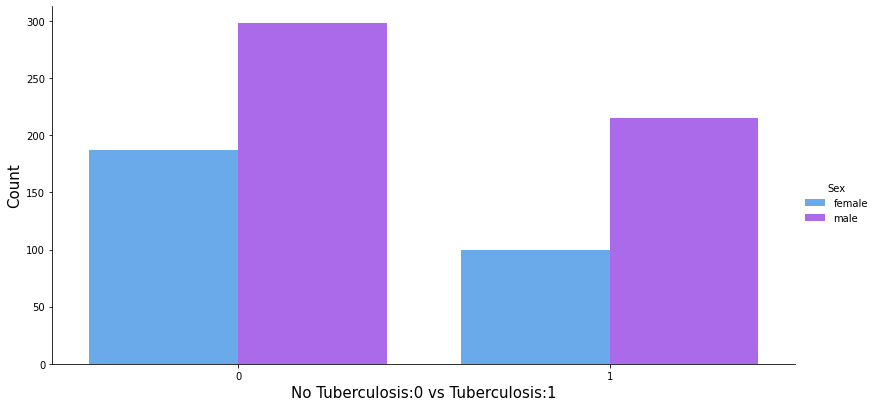

In [59]:
x = clinical_data.groupby(['target', 'Sex'])['Id'].count().to_frame().reset_index()
x.style.background_gradient(cmap='Reds')  

sns.catplot(x='target', y='Id', hue='Sex', data=x, kind="bar", height=5.5, aspect=2, palette="cool", capsize=.05)
plt.ylabel('Count', fontsize=15)
plt.xlabel('No Tuberculosis:0 vs Tuberculosis:1', fontsize=15);

In [64]:
# chi-square test
table = [[187, 298],
        [100, 215]]
stat, p, dof, expected = chi2_contingency(table)
print("stat:", stat)
print("p:", p)
print("dof", dof)

stat: 3.5601854315094537
p: 0.05918112740617956
dof 1


Text(0.5, 0, 'No Tuberculosis:0 vs Tuberculosis:1')

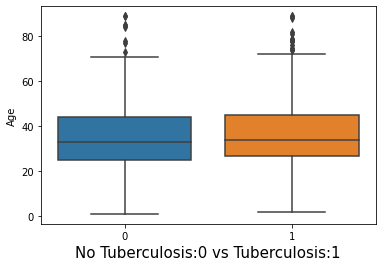

In [73]:
sns.boxplot(x="target", y="Age", data=clinical_data)
plt.xlabel('No Tuberculosis:0 vs Tuberculosis:1', fontsize=15)

In [71]:
# t-test
tb_age = clinical_data[clinical_data["target"]==1]["Age"]
ntb_age = clinical_data[clinical_data["target"]==0]["Age"]
stats.ttest_ind(tb_age, ntb_age)

Ttest_indResult(statistic=2.3318639490866078, pvalue=0.019955823537686462)

In [77]:
# wilcoxon rank sum
ranksums(tb_age, ntb_age)

RanksumsResult(statistic=1.655451475764082, pvalue=0.09783295166469244)

In [ ]:
img = Image.open(image_path)


In [79]:
def read_img_as_array(path, img_size=[50, 50]):
    '''
    Read input image as a narray
    '''

    img = Image.open(path)
    img = ImageOps.grayscale(img)
    # img = img.convert('RGB')

    img = img.resize(img_size)
    # normalize pixel values (range 0-1)
    data = np.asarray(img) / 255
    # print('data.shape', data.shape)
    return data

In [168]:
def process_path(path, IMAGE_SIZE=[100, 100], subsample_ratio=1):
    print('!!! Loading input images')
    ######## Load images as an array and their IDs as a list
    file_list = os.listdir(path=path)
    data_full = [] # array of vectorized images
    file_image_id = [] # list of image IDs

    for i in trange(len(file_list)//subsample_ratio):
    #for i in trange(len(file_list)):
        path0 = path + file_list[i]
        array = read_img_as_array(path0, IMAGE_SIZE).reshape(-1) # vectorize image
        data_full.append(array)

    data_full = np.asarray(data_full).T
    print('data_full.shape', data_full.shape)

    return data_full

In [169]:
image_path = "shared/data/LungSegmentation/CXR_png/"
X = process_path(image_path)

  0%|          | 0/800 [00:00<?, ?it/s]

!!! Loading input images


100%|██████████| 800/800 [03:49<00:00,  3.49it/s]


data_full.shape (10000, 800)


In [170]:
Y = clinical_data["target"].values
Y = np.reshape(Y, (1, len(Y))) # print(Y) # convert 2-dim array : 1 x 15000 (row vector)

In [108]:
covariates = clinical_data[["Age", "Sex"]].values
covariates = covariates.T
print(covariates.shape)

(2, 800)


In [153]:
for i in np.arange(covariates.shape[1]):
    if covariates[1,i] == 'female':
        covariates[1,i] = 0
    else:
        covariates[1,i] = 1

covariates = covariates.astype(float)

In [171]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
idx_list = []
for idx in cv.split(np.zeros(X.shape[1]), np.zeros(X.shape[1])):  # split(X,Y)
    idx_list.append(idx)

fold_idx = 0  # 0~4
train_idx, test_idx = idx_list[fold_idx]

Y_train = Y[:, train_idx]
Y_test = Y[:, test_idx]
X_train = X[:, train_idx]
X_test = X[:, test_idx]
covariates_train = covariates[:, train_idx]
covariates_test = covariates[:, test_idx]
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
print(covariates_train.shape)
print(covariates_test.shape)

(10000, 640)
(10000, 160)
(1, 640)
(1, 160)
(2, 640)
(2, 160)


In [155]:
covariates_train

array([[31., 50., 31., ..., 39., 47., 26.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

In [188]:
# LMF
r = 25
xi = 5

LMF_class = LMF(X=[X_train, Y_train],  # [X = [X,Y] : data (d1 x n), label (d2 x n)]
                #X_auxiliary=covariates_train, # covariate data (d3 x n) that is subject to LR but not to NMF
                X_test=[X_test, Y_test], # test data, test label
                #X_test_aux=covariates_test, # cov test data (d3 x n)
                n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                iterations=100,
                ini_loading=None,  # Initialization for [W1, W2, W3] = [(dict), (reg. coeff), (reg. coeff for cov var.)]
                xi=xi,  # weight on label reconstruction error
                a0=0,  # L1 regularizer for dictionary W[0]
                a1=0,  # L1 regularizer for code matrix H
                a2=0,  # L1 regularizer for linear coefficients beta
                full_dim=True) # if true, dictionary is Id with full dimension --> Pure regression

In [ ]:
results_dict = LMF_class.train_logistic(iter=100, subsample_size=100, if_compute_recons_error=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
LMF_class.validation(results_dict,
                     X_test = [X_train, Y_train],
                     #X_test_aux = covariates_test,
                     sub_iter=100,
                     stopping_grad_ratio=0.0001)

In [182]:
# LMF
r = 25
xi = 10

LMF_class = LMF(X=[X_train, Y_train],  # [X = [X,Y] : data (d1 x n), label (d2 x n)]
                X_auxiliary=covariates_train, # covariate data (d3 x n) that is subject to LR but not to NMF
                X_test=[X_test, Y_test], # test data, test label
                X_test_aux=covariates_test, # cov test data (d3 x n)
                n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                iterations=100,
                ini_loading=None,  # Initialization for [W1, W2, W3] = [(dict), (reg. coeff), (reg. coeff for cov var.)]
                xi=xi,  # weight on label reconstruction error
                a0=0,  # L1 regularizer for dictionary W[0]
                a1=0,  # L1 regularizer for code matrix H
                a2=0,  # L1 regularizer for linear coefficients beta
                full_dim=False) # if true, dictionary is Id with full dimension --> Pure regression

In [183]:
results_dict = LMF_class.train_logistic(iter=100, subsample_size=100, if_compute_recons_error=True)

  0%|          | 0/100 [00:00<?, ?it/s]/rhome/jlee1183/LMF/src/LMF.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  error_label = np.sum(np.log(1+np.exp(W[1] @ H_ext))) - X[1] @ (W[1] @ H_ext).T
  1%|          | 1/100 [00:01<03:13,  1.95s/it]/rhome/jlee1183/LMF/src/LMF.py:190: RuntimeWarning: overflow encountered in exp
  D = W[1] @ H1_ext


!!! Iteration 0: Reconstruction error [Data, Label] = [830.812640.3, 115770.523909.3]
!!! W norm 74.03789747822309


/rhome/jlee1183/LMF/src/LMF.py:134: RuntimeWarning: overflow encountered in exp
  A = H @ H.T
 11%|█         | 11/100 [00:22<03:13,  2.17s/it]

!!! Iteration 10: Reconstruction error [Data, Label] = [387.447496.3, 97300.944355.3]
!!! W norm 48.64175175536657


 21%|██        | 21/100 [00:43<02:47,  2.12s/it]

!!! Iteration 20: Reconstruction error [Data, Label] = [344.848883.3, 25.443723.3]
!!! W norm 45.454089400545385


 31%|███       | 31/100 [01:04<02:25,  2.11s/it]

!!! Iteration 30: Reconstruction error [Data, Label] = [324.973376.3, 13.259763.3]
!!! W norm 43.21434811971221


 41%|████      | 41/100 [01:24<02:04,  2.11s/it]

!!! Iteration 40: Reconstruction error [Data, Label] = [310.763192.3, 12.144880.3]
!!! W norm 41.51379335997233


 51%|█████     | 51/100 [01:45<01:43,  2.12s/it]

!!! Iteration 50: Reconstruction error [Data, Label] = [300.128905.3, 10.435195.3]
!!! W norm 40.06162719233662


 61%|██████    | 61/100 [02:06<01:22,  2.13s/it]

!!! Iteration 60: Reconstruction error [Data, Label] = [292.111416.3, 9.683661.3]
!!! W norm 38.823223960562416


 71%|███████   | 71/100 [02:26<01:00,  2.10s/it]

!!! Iteration 70: Reconstruction error [Data, Label] = [285.390406.3, 7.978557.3]
!!! W norm 37.779721637165245


 81%|████████  | 81/100 [02:47<00:40,  2.11s/it]

!!! Iteration 80: Reconstruction error [Data, Label] = [279.892538.3, 7.206608.3]
!!! W norm 36.9129573899627


 91%|█████████ | 91/100 [03:07<00:19,  2.13s/it]

!!! Iteration 90: Reconstruction error [Data, Label] = [275.331399.3, 6.410269.3]
!!! W norm 36.27964467497289


100%|██████████| 100/100 [03:26<00:00,  2.06s/it]


In [184]:
LMF_class.validation(results_dict,
                     X_test = [X_test, Y_test],
                     X_test_aux = covariates_test,
                     sub_iter=100,
                     stopping_grad_ratio=0.0001)

!!! [threshold, AUC] =  [0.0, 0.425]


{'loading': [array([[0.01494073, 0.        , 0.04554109, ..., 0.        , 0.        ,
          0.02887875],
         [0.00947745, 0.        , 0.03165253, ..., 0.        , 0.        ,
          0.01679582],
         [0.00637554, 0.        , 0.0318379 , ..., 0.        , 0.        ,
          0.01828072],
         ...,
         [0.03522654, 0.        , 0.12314797, ..., 0.        , 0.        ,
          0.07573304],
         [0.04256853, 0.        , 0.10459951, ..., 0.        , 0.00530886,
          0.12790022],
         [0.01668617, 0.        , 0.06370484, ..., 0.05406157, 0.03616939,
          0.13879932]]),
  array([[-0.25622271, -0.16295339, -0.02551325,  0.61422373,  0.43527326,
           4.75331604,  3.02242032,  3.62080771,  1.71195584,  5.49509732,
           5.27860217,  1.16057326,  2.38737162, -0.3815131 ,  0.31884927,
           1.55090702,  6.11725341,  3.68835785,  0.34737074,  0.10243272,
           0.23573552, -0.20295776,  0.58402395,  0.42650119,  0.32169212,
          